# Inference and Validation

훈련된 모형을 사용하여 prediction을 수행할 수 있다. 이것을 **inference**라고 부른다. 이 과정에서 훈련 데이터에 대해 과대적합이 일어날 수 있는데 이것을 **overfitting**이라고 한다. overfitting를 확인하기 위해서 훈련데이터를 **validation** set으로 나눈다.  overfitting 문제를 해결하기 위해서 regularization(규제화) 또는 dropout을 수행한다.  훈련을 진행하는 과정에서 validation performance 를 모니터링하여 overfitting이 발생하는지 확인할 수 있다.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('TensorFlow version:', tf.__version__)
print('tf.keras version:', tf.keras.__version__)
print('Running on GPU' if tf.test.is_gpu_available() else 'GPU device not found. Running on CPU')

Using:
TensorFlow version: 2.7.0
tf.keras version: 2.7.0
GPU device not found. Running on CPU


## 패션 MNIST 데이터셋 임포트하기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:
<img src="../assets/fashion-mnist-sprite.png" alt="Fashion MNIST sprite"  width="600">

패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 [MNIST](http://yann.lecun.com/exdb/mnist/) 데이터셋을 대신해서 자주 사용됩니다. MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있습니다. 여기서 사용하려는 옷 이미지와 동일한 포맷입니다.

패션 MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제이고 다양한 예제를 만들기 위해 선택했습니다. 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다.

네트워크를 훈련하는데 60,000개의 이미지를 사용합니다. 그다음 네트워크가 얼마나 정확하게 이미지를 분류하는지 10,000개의 이미지로 평가하겠습니다. 패션 MNIST 데이터셋은 텐서플로에서 바로 임포트하여 적재할 수 있습니다:

## Load the Dataset

Fashion-MNIST dataset을 load 한다. 이번 예제에서는 전체 데이터를 train dataset, validation dataset, test dataset으로 나눈다.

`train`은 60,000 examples을 포함하고 `test` 는 10,000 examples을 포함하고 있다.

train dataset에서 일부 10,000 건의 example을 별도의 validation dataset으로 지정한다. 


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:

* `train_images`와 `train_labels` 배열은 모델 학습에 사용되는 *훈련 세트*입니다.
* `test_images`와 `test_labels` 배열은 모델 테스트에 사용되는 *테스트 세트*입니다.

이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이입니다. *레이블*(label)은 0에서 9까지의 정수 배열입니다. 이 값은 이미지에 있는 옷의 *클래스*(class)를 나타냅니다:

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑되어 있습니다. 데이터셋에 *클래스 이름*이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장합니다:

## 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보자. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여준다. 각 이미지는 28x28 픽셀로 표현된다:

In [6]:
x_train.shape

(60000, 28, 28)

비슷하게 훈련 세트에는 60,000개의 레이블이 있다:

In [7]:
len(y_train)

60000

각 레이블은 0과 9사이의 정수이다:

In [8]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있다. 이 이미지도 28x28 픽셀로 표현된다:

In [9]:
x_test.shape

(10000, 28, 28)

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있다:

In [10]:
len(y_train)

60000

## 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다:

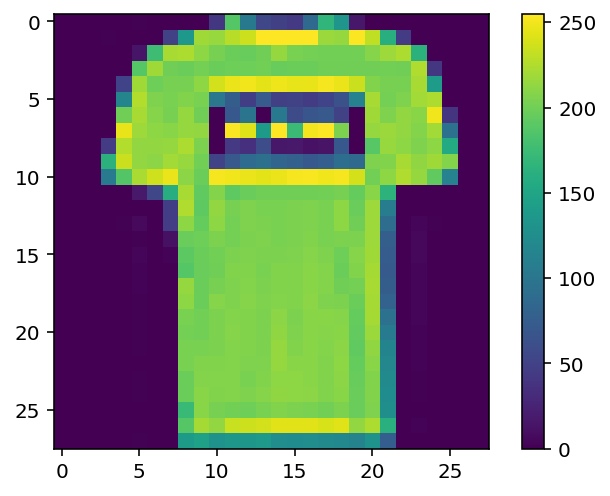

In [11]:
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.grid(False)
plt.show()

In [12]:
X_train = x_train / 255.0
X_test = x_test / 255.0

In [13]:
# fashion MNIST dataset class name
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Build the Model



In [14]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the Model with the Validation Set

앞서 예제와 같은 방법으로 모형을 훈련할 수 있다. 

매 training epoch 마다 training set과 validation set에 대한 loss를 계산한다. 이를 통해 모형의 학습 과정을 모니터링 할 수 있다. validation set은 모형의 훈련에 사용되지 않는다. 대신 모형이 overfitting 되지 않는지를 확인할 수 있다.

`.fit` method 에서 `validation_data=validation_batches` argument에서 validation set을 지정하여 수행한다.

In [16]:
EPOCHS = 40

history = model.fit(X_train, y_train,
                    epochs = EPOCHS,
                    validation_split = 0.3)

Epoch 1/40
1313/1313 [==============================] - 4s 3ms/step - loss: 0.5260 - accuracy: 0.8099 - val_loss: 0.4276 - val_accuracy: 0.8473
Epoch 2/40
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3891 - accuracy: 0.8576 - val_loss: 0.4004 - val_accuracy: 0.8546
Epoch 3/40
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3490 - accuracy: 0.8704 - val_loss: 0.3970 - val_accuracy: 0.8550
Epoch 4/40
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3218 - accuracy: 0.8818 - val_loss: 0.3638 - val_accuracy: 0.8687
Epoch 5/40
1313/1313 [==============================] - 4s 3ms/step - loss: 0.2995 - accuracy: 0.8889 - val_loss: 0.3463 - val_accuracy: 0.8727
Epoch 6/40
1313/1313 [==============================] - 4s 3ms/step - loss: 0.2868 - accuracy: 0.8930 - val_loss: 0.3379 - val_accuracy: 0.8814
Epoch 7/40
1313/1313 [==============================] - 4s 3ms/step - loss: 0.2744 - accuracy: 0.8958 - val_loss: 0.3387 - val_accuracy:

## Loss and Validation Plots

위에서 40 epoch 으로 모형을 훈련하였다. 훈련 결과를 시각화하여 표현해 보자. 

해당 결과를 확인해 보면 validation set에 대한 loss보다 training dataset에 대한 loss는 매우 작은 것을 볼 수 있는데 이를 통해 해당 모형이 overfitting 되었다고 판단할 수 있다. 

모형이 훈련될 때 training set 과 the validation set 모두에 대해 loss 와 accuracy 를 확인한다. `.fit` method는 `history` object를 리턴한다. `history.history` 속성은 **dictionary**로  training accuracy 와 loss 를 각 epochs 마다 기록한다.  

In [17]:
# Check that history.history is a dictionary
print('history.history has type:', type(history.history))

# Print the keys of the history.history dictionary
print('\nThe keys of history.history are:', list(history.history.keys()))

history.history has type: <class 'dict'>

The keys of history.history are: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


`history.history` dictionary 를 plot으로 시각화 하면 해당 모형이 훈련되는 과정에서 loss와 accuracy를 확인할 수 있다.

In [18]:
def plot_history(training_accuracy, validation_accuracy, training_loss, validation_loss) :
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

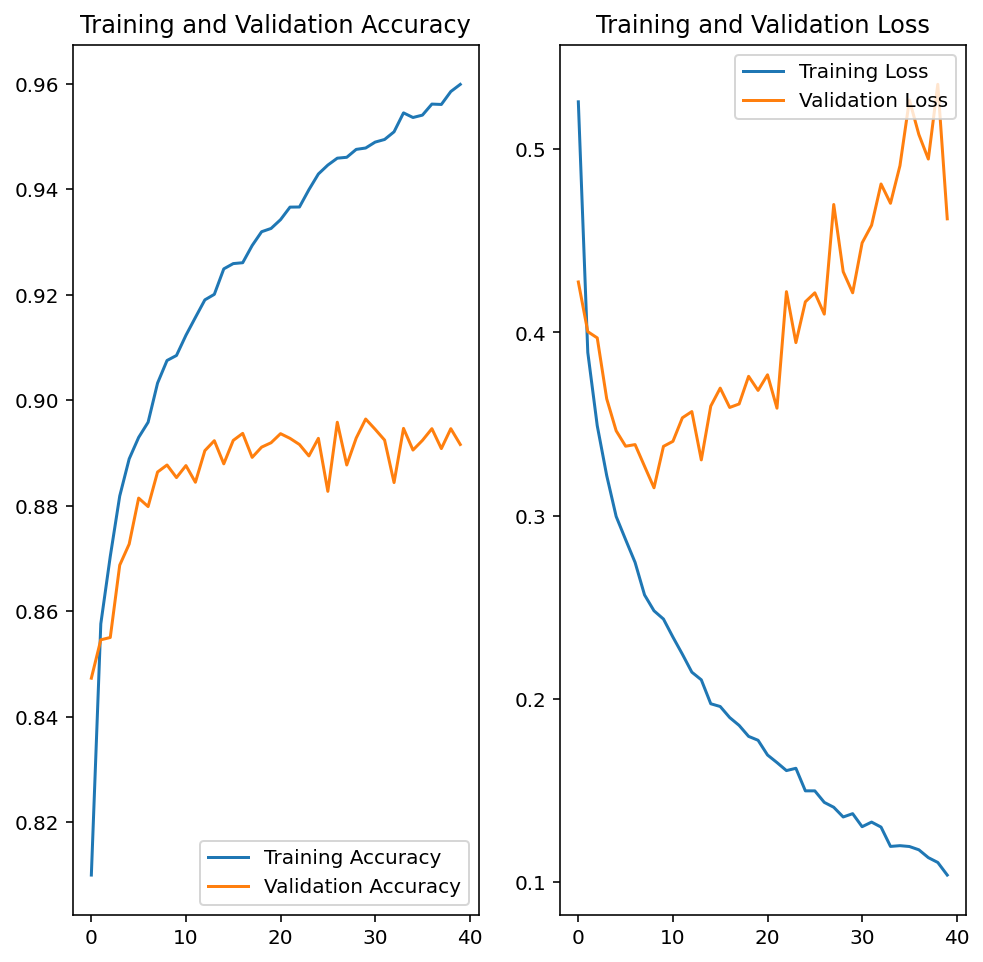

In [19]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_history(training_accuracy, validation_accuracy, training_loss, validation_loss)

## Early Stopping

overfitting 문제를 해결하는 방법 중 하나가 Early Stopping이다. 
overfitting이 되면 모형이 일반화(generalize)에 실패하여 train set에 대해서는 과대 적합되고 validation set에는 오히려 정확도가 떨어지게 된다.

시각화 결과를 살펴보면 훈련 시작시 validation loss가 감소하기 시작하고 몇 epoch 이후에는 평준화되고 이후 증가하기 시작한다는 것을 알 수 있다. 

이때 overfitting이 발생하기 전에 훈련을 조기 종료하는 방법이 Early Stopping이다. 

**early-stopping**을 하기 위해서 `tf.keras`에서는 **callback**을 사용한다. `.fit()` method 에서 `callbacks` keyword argument를 사용한다. 

```python
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
```

* `monitor` argument : training을 종료하기 위해서 모니터링할 성능 지표를 지정한다. 
* `patience` argument : 정해진 epoch 수 모니터링 지표가 상당한 개선이 이루어지지 않으면 훈련을 중단한다. 
* `min_delta` argument :  개선된 것으로 판단할 수 있는 최소값을 지정한다. 

참고) [EarlyStopping 
documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping#class_earlystopping).

In [20]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

EPOCHS = 100

history = model.fit(X_train, y_train,
                    epochs = EPOCHS,
                    validation_split=0.3,
                    callbacks=[early_stopping])

Epoch 1/100
1313/1313 [==============================] - 4s 3ms/step - loss: 0.5245 - accuracy: 0.8099 - val_loss: 0.4151 - val_accuracy: 0.8539
Epoch 2/100
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3936 - accuracy: 0.8562 - val_loss: 0.3888 - val_accuracy: 0.8612
Epoch 3/100
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3472 - accuracy: 0.8711 - val_loss: 0.3556 - val_accuracy: 0.8728
Epoch 4/100
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3215 - accuracy: 0.8816 - val_loss: 0.3576 - val_accuracy: 0.8718
Epoch 5/100
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3004 - accuracy: 0.8875 - val_loss: 0.3458 - val_accuracy: 0.8747
Epoch 6/100
1313/1313 [==============================] - 4s 3ms/step - loss: 0.2857 - accuracy: 0.8925 - val_loss: 0.3442 - val_accuracy: 0.8717
Epoch 7/100
1313/1313 [==============================] - 4s 3ms/step - loss: 0.2734 - accuracy: 0.8977 - val_loss: 0.3454 - val_ac

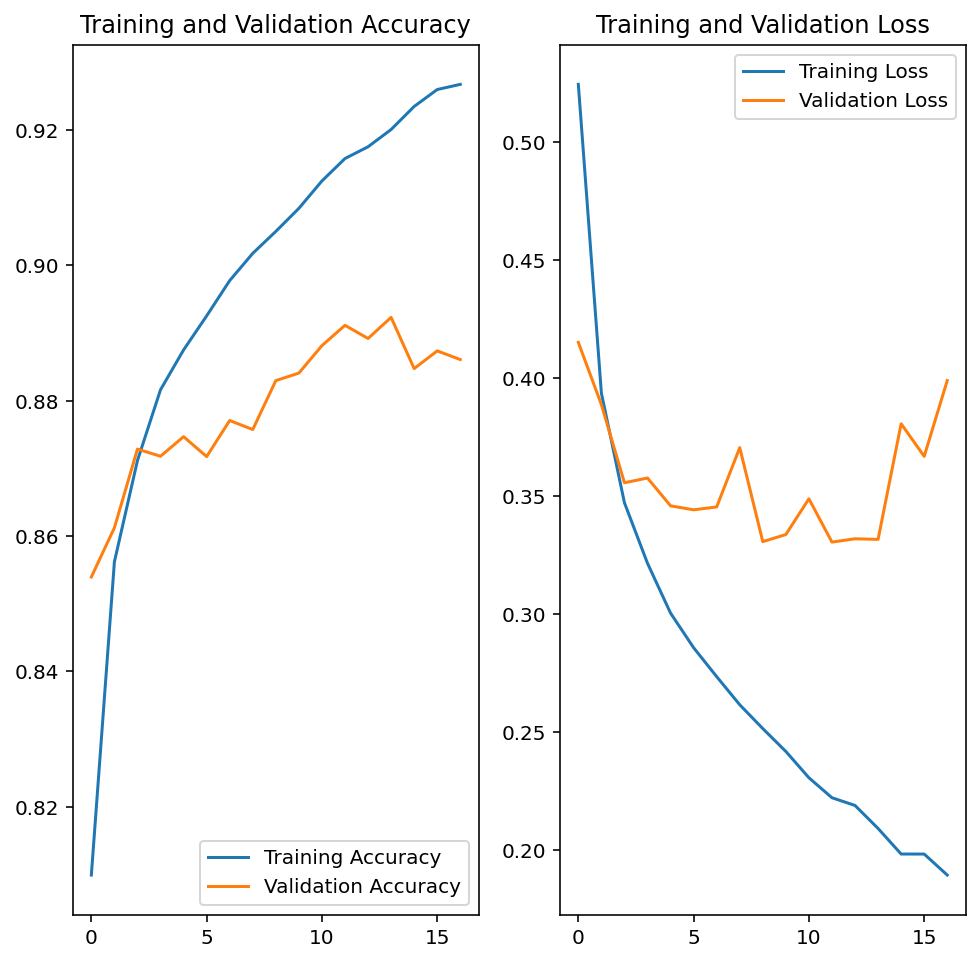

In [21]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_history(training_accuracy, validation_accuracy, training_loss, validation_loss)

## Dropout

overfitting 을 해결할 수 있는 또다른 방법으로는  **dropout**이 있다. dropout 은 모형의 훈련과정에서 random하게 network의 일부 neurons을 삭제하는 것이다.  `tf.keras`에서는 `tf.keras.layers.Dropout()` layers 를 활용한다. 

```python
tf.keras.layers.Dropout(rate)
```

* rate : 훈련 중 임의로 삭제할 neuron의 비율을 지정한다. (0~1사이의 값)

input layer에 대해서는 dropout을 지정하지 않는다. 또한 훈련과정에서만 dropout 이 적용되고 훈련이 끝난 모형을 prediction에 사용할때는 dropout이 적용되지 않는다. 

> **Exercise:** 이전에 생성한 모형에 3개의 dropout layers를 추가한다. 이때 `rate=0.2`로 지정하시오. 그리고 해당 모형을 다시 훈련시키고 overfitting 이 해결되는지 확인해 보시오.

In [22]:

## Solution
my_model = tf.keras.Sequential([
           tf.keras.layers.Flatten(input_shape=(28,28,1)),
           tf.keras.layers.Dense(256, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(128, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(64, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(10, activation = 'softmax')
])

my_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

EPOCHS = 30

history = my_model.fit(X_train, y_train,
                       epochs=EPOCHS,
                       validation_split =0.3)

Epoch 1/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.6325 - accuracy: 0.7690 - val_loss: 0.4363 - val_accuracy: 0.8407
Epoch 2/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.4591 - accuracy: 0.8352 - val_loss: 0.4021 - val_accuracy: 0.8537
Epoch 3/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.4146 - accuracy: 0.8499 - val_loss: 0.3706 - val_accuracy: 0.8641
Epoch 4/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.3916 - accuracy: 0.8588 - val_loss: 0.3590 - val_accuracy: 0.8678
Epoch 5/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.3702 - accuracy: 0.8654 - val_loss: 0.3488 - val_accuracy: 0.8717
Epoch 6/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.3590 - accuracy: 0.8699 - val_loss: 0.3497 - val_accuracy: 0.87156 - accuracy
Epoch 7/30
1313/1313 [==============================] - 3s 2ms/step - loss: 0.3448 - accuracy: 0.8741 - val_loss: 0.3548 - v

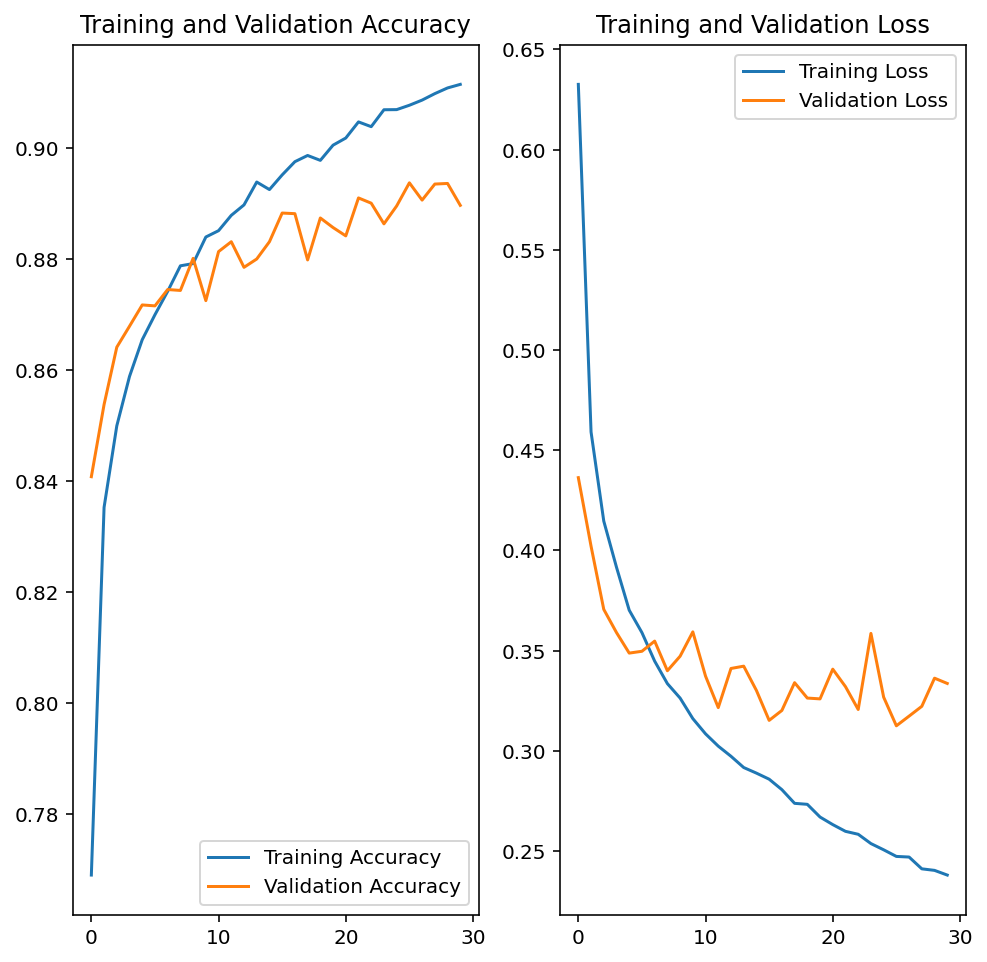

In [23]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_history(training_accuracy, validation_accuracy, training_loss, validation_loss)

## Inference

훈련된 모형을 사용하여 prediction을 수행하고 해당 결과를 시각화 하며 표현해 본다.

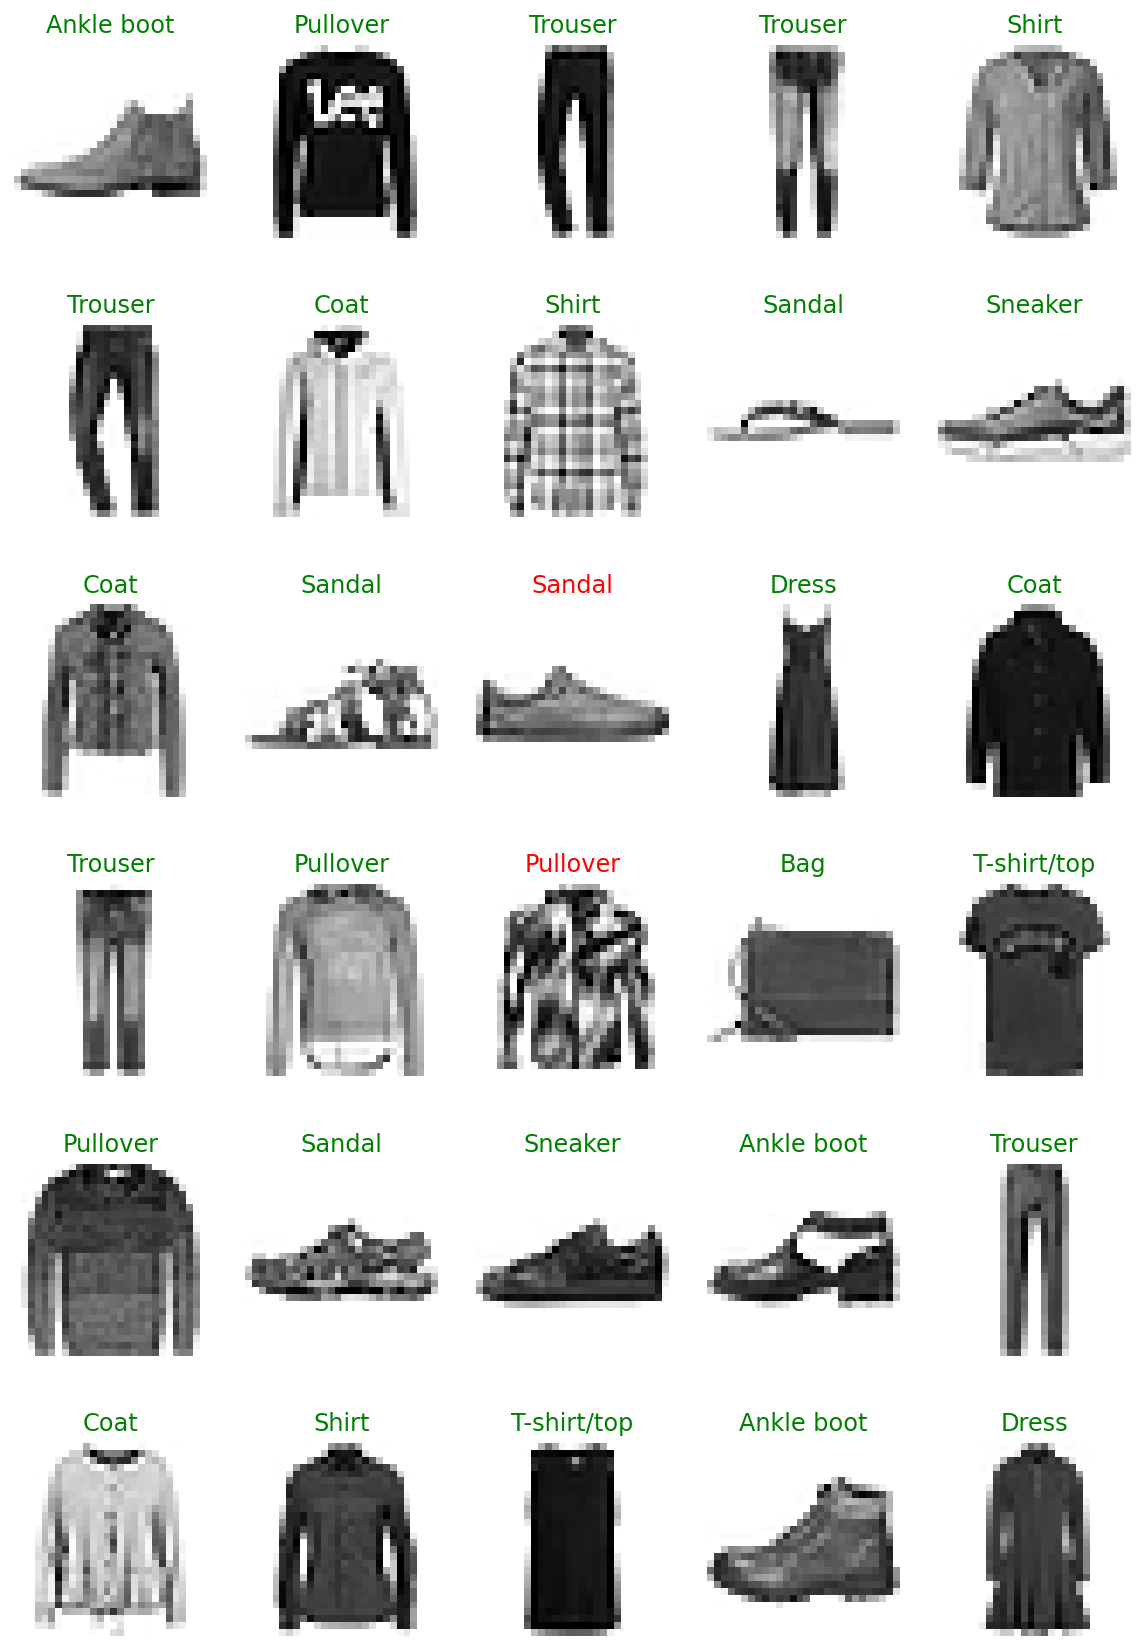

In [24]:
ps = model.predict(X_test)
images = X_test.squeeze()
labels = y_test

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')